# Very Simple Linear Regression

Try a simple linear regression based model for predicting cross-domain correlation structures.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import sys

In [2]:
sys.path.append("..")
from mlcdc import KerasFeeder

In [3]:
ds = xr.open_zarr('../data/tcorr.predictors0.10lon.10lat.-1alev.-1olev.-1member.zarr')
ds['atm_speed_srf'] = ds.atm_wind_speed.isel(alev=-1)
ds['ocn_speed_srf'] = ds.ocn_speed.isel(olev=0)
ds['ocn_u_srf'] = ds['ocn_u'].isel(olev=0)
ds['ocn_v_srf'] = ds['ocn_v'].isel(olev=0)
ds['atm_speed_srf'].attrs['long_name'] = 'derived atmospheric surface wind speed'
ds['ocn_speed_srf'].attrs['long_name'] = 'derived ocean surface current speed'
ds['ocn_u_srf'].attrs['long_name'] = 'derived zonal ocean surface current speed'
ds['ocn_v_srf'].attrs['long_name'] = 'derived meridional ocean surface current speed'

In [5]:
features = [
    #'atm_cnvprcp_ave', # no idea what this is
    #'atm_ast',
    'atm_T',
    'atm_q2m',
    'atm_qrain',
    #'atm_t2m',
    #'atm_totprcp_ave',
    'atm_tprcp',
    #'atm_u_srf',
    #'atm_v_srf',
    'atm_speed_srf',
    #'ocn_MEKE',
    #'ocn_MEKE_Kh', # probably need MEKE, if anything, not the diffusivity ...
    'ocn_MLD',
    #'ocn_MLD_MLE_filtered', # just use instantaneous, not time filtered version...
    #'ocn_ave_ssh', # use instantaneous version
    'ocn_sfc',
    #'ocn_sst',
    #'ocn_u_srf',
    #'ocn_v_srf',
    'ocn_speed_srf',
    'ocn_Temp',
]

In [6]:
for key in features:
    print(f"{key:<24s}: {ds[key].long_name}")

atm_T                   : air_temperature
atm_q2m                 : q2m
atm_qrain               : qrain
atm_tprcp               : tprcp
atm_speed_srf           : derived atmospheric surface wind speed
ocn_MLD                 : Instantaneous active mixing layer depth
ocn_sfc                 : Free surface Height
ocn_speed_srf           : derived ocean surface current speed
ocn_Temp                : Potential Temperature


### Quick look at correlations

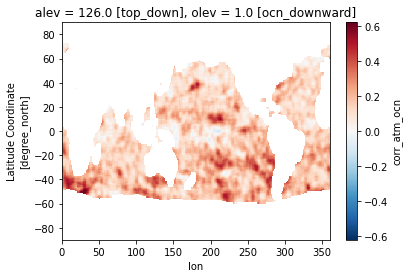

In [7]:
ds.corr_atm_ocn.isel(olev=0,alev=-1).plot()

## Prepare the data

Using `KerasFeeder`

In [8]:
kf = KerasFeeder(feature_names=features,
                 label_name='corr_atm_ocn',
                 mask_name='ocn_mask',
                 training_fraction=0.8,
                 load_into_memory=True)

In [9]:
kf

KerasFeeder:

    Features:
        atm_T, atm_q2m, atm_qrain, atm_tprcp, atm_speed_srf, ocn_MLD, ocn_sfc, ocn_speed_srf, ocn_Temp
        status = unset

    Labels:
        corr_atm_ocn
        status = unset

    Inputs:
        None
        status = unset

 --- 
    Training Fraction       : 0.8
    Normalize Data          : True
    Load into Memory        : True

In [10]:
kf(ds)

In [11]:
kf

KerasFeeder:

    Features:
        atm_T, atm_q2m, atm_qrain, atm_tprcp, atm_speed_srf, ocn_MLD, ocn_sfc, ocn_speed_srf, ocn_Temp
        status = set

    Labels:
        corr_atm_ocn
        status = set

    Inputs:
        [<KerasTensor: shape=(None, 74) dtype=float32 (created by layer 'atm_T')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'atm_q2m')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'atm_qrain')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'atm_tprcp')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'atm_speed_srf')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ocn_MLD')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ocn_sfc')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ocn_speed_srf')>, <KerasTensor: shape=(None, 44) dtype=float32 (created by layer 'ocn_Temp')>]
        status = set

 --- 
    Training Fraction       : 0.8
    Normalize Dat

## Create the model

Input layers are created in `KerasFeeder`, for simple linear regression, just merge the inputs and feed to output.

In [12]:
merge = keras.layers.concatenate(kf.inputs)

In [13]:
output = keras.layers.Dense(
    units=len(kf.labels['training'].z), name="ao_corr",
    kernel_regularizer=keras.regularizers.L1(1e-7)
    #kernel_regularizer=keras.regularizers.L1L2(5e-4,5e-4)
    #kernel_regularizer=keras.regularizers.L2(1e-3)
)(merge)

2022-09-08 16:15:56.242104: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
model = keras.Model(
    inputs=kf.inputs,
    outputs=[output]
)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 atm_T (InputLayer)             [(None, 74)]         0           []                               
                                                                                                  
 atm_q2m (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 atm_qrain (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 atm_tprcp (InputLayer)         [(None, 1)]          0           []                               
                                                                                              

In [16]:
n_z = len(kf.labels['training'].z)
n_z*11 + n_z

39072

### Determine optimization process and train it

For now, use MSE loss function and Adam optimization.
Options in [keras regression losses](https://keras.io/api/losses/regression_losses/)
and [keras optimizers](https://keras.io/api/optimizers/) 

- What learning rate to use?
- What regularization type and parameter to use?
- How to do this in parallel rather than pulling everything into memory here?

TBD: hyperparameter optimization

In [17]:
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=1e-3,
    ),
    loss=keras.losses.MeanSquaredError()
)

In [18]:
%%time
history = model.fit(
    x=kf.x_training, 
    y=kf.labels['training'].values,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
)

Epoch 1/100
496/496 [==============================] - 6s 11ms/step - loss: 0.0049 - val_loss: 0.0038
Epoch 2/100
496/496 [==============================] - 6s 12ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 3/100
496/496 [==============================] - 6s 12ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 4/100
496/496 [==============================] - 6s 11ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 5/100
496/496 [==============================] - 6s 12ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 6/100
496/496 [==============================] - 6s 11ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 7/100
496/496 [==============================] - 6s 11ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/100
496/496 [==============================] - 6s 12ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 9/100
496/496 [==============================] - 6s 12ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 10/100
496/496 [==============================] - 6s 11ms/step - loss: 0.003

496/496 [==============================] - 4s 9ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 82/100
496/496 [==============================] - 5s 10ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 83/100
496/496 [==============================] - 4s 9ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 84/100
496/496 [==============================] - 4s 9ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 85/100
496/496 [==============================] - 5s 10ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 86/100
496/496 [==============================] - 4s 9ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 87/100
496/496 [==============================] - 4s 8ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 88/100
496/496 [==============================] - 4s 9ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 89/100
496/496 [==============================] - 4s 9ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 90/100
496/496 [==============================] - 4s 9ms/step - loss: 0.0031 - val_loss

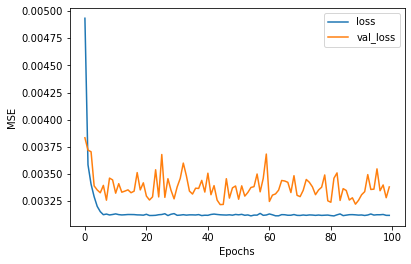

In [19]:
fig,ax=plt.subplots()
for key in ['loss','val_loss']:
    ax.plot(history.history[key],label=key)
ax.set(xlabel='Epochs', ylabel='MSE')
ax.legend()

Without regularization, this loss curve looked like a random process. Now it's actually (mostly) decreasing.

In [20]:
model.evaluate(
    x=kf.x_testing, 
    y=kf.labels['testing'].values
)

619/619 [==============================] - 2s 3ms/step - loss: 0.0034


0.0033842192497104406

In [21]:
prediction = model.predict(kf.x_testing)

619/619 [==============================] - 1s 1ms/step


In [22]:
xpred = xr.DataArray(prediction,coords=kf.labels['testing'].coords, dims=kf.labels['testing'].dims)

In [23]:
xpred = xpred.unstack('z')

[Text(0.5, 0, 'Truth'), Text(0, 0.5, 'Prediction')]

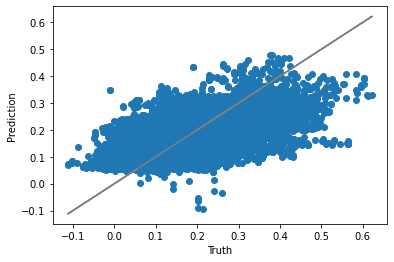

In [24]:
fig, ax = plt.subplots()
ax.scatter(kf.labels['testing'].unstack('z').isel(alev=-1,olev=0),
           xpred.isel(alev=-1,olev=0),
          )
ax.plot(kf.labels['testing'].unstack('z').isel(alev=-1,olev=0),
        kf.labels['testing'].unstack('z').isel(alev=-1,olev=0),
        color='gray')
ax.set(xlabel='Truth',ylabel='Prediction')

💩